# Dataset Properties in the Classification Outcome

To verify that our model is not dependent on the dataset used, an analysis has been carried out on the original dataset and on the outputs obtained after applying the different models. This analysis consisted of obtaining the Spearman correlation between the distributions of the most frequent terms found in tweets labelled as "0" or "1" in each of the categories in each of the tests performed. A correlation close to 1.0 with a p-value of less than 0.05 would indicate that the distributions of the most frequent terms analysed are statistically similar, thus being a valid and unbiased dataset for training the models. Likewise, keeping the same distribution at the output would indicate that the models do not increase or decrease the possible bias that could be present in the dataset.

In [1]:
import os
import pandas as pd
import numpy as np
import json
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer
import nltk.data
from nltk.tokenize import TweetTokenizer, word_tokenize
import spacy
import preprocessor as p
import regex as re
import string
import seaborn as sns
import sklearn
import io
import csv
import statistics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from preProcess import preprocess_data
import plotly.express as px

nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 300
#data2_1.info(memory_usage="deep")


C:\Users\MICROSOFT\Anaconda3\envs\edoct2022\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MICROSOFT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MICROSOFT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def usageForType(df):
    for ctype in ['float','float64','int64','int','object','datetime','category']:
        columnType = df.select_dtypes(include=[ctype])
        meanMemoryUsage = columnType.memory_usage(deep=True).mean()
        meanMemoryUsageMB = meanMemoryUsage / 1024 ** 2
        print("Memory usage for type ",ctype , " : {:0.5f} MB".format(meanMemoryUsageMB))

In [4]:
tweets = pd.read_csv('tweets2.csv', encoding='utf8', error_bad_lines=False)

In [5]:
tweets.head(2)

,Unnamed: 0,id_tweet,stream_group,text_orig,Commercial,POLITICS,ED,Family,ED_patience,ProED,Offensive,Informative,Scientific,Sad,hashtag,text,Segmented#
0,0,"1,31851E+34",1,"RT @beatED: Learn more about anorexia and bulimia, as well as other eating disorders, here: https://t.co/Aj2HbjRH39 @BBCPanorama #BBCPanorama",0,0,1,0.0,0,0,0,1,0,0.0,['BBCPanorama'],"['learn', 'anorexia', 'bulimia', 'well', 'eating', 'disorder']",bbc panorama
1,1,"1,31851E+34",1,"A woman tries to balance her relationships with her mother and teenage daughter while under the shadow of #anorexia in the atmospheric British drama #BodyofWater. \r\n\r\nAt Depot from Friday, book now: https://lewesdepot.org/film/body-of-water\r\n",0,0,1,0.0,0,0,0,0,0,0.0,"['anorexia', 'BodyofWater']","['woman', 'try', 'balance', 'relationship', 'mother', 'teenage', 'daughter', 'shadow', 'atmospheric', 'british', 'drama', 'depot', 'friday', 'book']",anorexia bodyof water


In [6]:
tweets.columns=['num1','id_tw','stream_group','text_orig','f1_commercial','f2_politics','f3_ed','f4_family','f5_edpatient','f6_proed','f7_offensive','f8_info','f9_scientific','f10_sad','hashtag','text','segmented']

In [7]:
cols=['f1_commercial','f2_politics','f3_ed','f4_family','f5_edpatient','f6_proed','f7_offensive','f8_info','f9_scientific','f10_sad']

In [8]:
punctuations = "¡!#$%&'()*+,-./:;<=>¿?@[\]^_`{|}~"

def read_txt(filename):
    list = []
    with open(filename, 'r', encoding='utf-8') as f:
        data = f.readlines()
        for line in data:
            list.append(str(line).replace('\n', ''))
    return list

stopwords = read_txt('english_stopwords.txt')

stemmer = SnowballStemmer('english')


def clean_accents(tweet):
    tweet = re.sub(r"[àáâãäå]", "a", tweet)
    tweet = re.sub(r"ç", "c", tweet)
    tweet = re.sub(r"[èéêë]", "e", tweet)
    tweet = re.sub(r"[ìíîï]", "i", tweet)
    tweet = re.sub(r"[òóôõö]", "o", tweet)
    tweet = re.sub(r"[ùúûü]", "u", tweet)
    tweet = re.sub(r"[ýÿ]", "y", tweet)

    return tweet

def clean_tweet(tweet, stem = False):
    tweet = tweet.lower().strip()
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)
    tweet = re.sub(r'http?:\/\/\S+', '', tweet)
    tweet = re.sub(r'www?:\/\/\S+', '', tweet)
    tweet = re.sub(r'\s([@#][\w_-]+)', "", tweet)
    tweet = re.sub(r"\n", " ", tweet)
    tweet = clean_accents(tweet)
    tweet = re.sub(r"\b(a*ha+h[ha]*|o?l+o+l+[ol]*|x+d+[x*d*]*|a*ja+[j+a+]+)\b", "<risas>", tweet)
    for symbol in punctuations:
        tweet = tweet.replace(symbol, "")
    tokens = []
    for token in tweet.strip().split():
        if token not in punctuations and token not in stopwords:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)



In [9]:
tweets1 = tweets.copy()
tweets1['text_cleaned'] = tweets['text_orig'].apply(lambda s : clean_tweet(s))
print(tweets1['text_cleaned'].head(5))

0                                                                   rt learn anorexia bulimia well eating disorders
1      woman tries balance relationships mother teenage daughter shadow atmospheric british drama depot friday book
2                                     full diagnosis therapist legit told mom anorexia nevrususu poor mom sat 👁👄👁oh
3                                          highercalorie diets patients anorexia nervosa shorten hospital stays via
4    tw ed ment freddie pissed amazing way got anorexic bulimic actress play foodobsessed character never sit right
Name: text_cleaned, dtype: object


In [13]:

tweets1['text_cleaned'][tweets1['text_cleaned'].str.contains("anorexia")]

0                                                                                                                                                                                                  rt learn anorexia bulimia well eating disorders
2                                                                                                                                                                    full diagnosis therapist legit told mom anorexia nevrususu poor mom sat 👁👄👁oh
3                                                                                                                                                                         highercalorie diets patients anorexia nervosa shorten hospital stays via
5                                                       brains woman suffering one healthy weight one considered obese patient suppresses positve reward stimulus obese woman patient receive rewards stimulus however area wider anorexia patient
7                           

In [9]:
os.getcwd()

'C:\\JUP\\tib1\\Combining-Knowledge-Graphs-and-Deep-Learning-techniques-for-Categorizing-Tweets\\kge_ml_dl_models'

In [10]:
tweets1.text_cleaned.str.split(expand=True).stack().value_counts()
tweets1b =  preprocess_data(tweets1, 'text_orig')

In [12]:
tokens=pd.DataFrame(tweets1b)

In [13]:
tweets1['tokens'] = tokens
tweets1["tokens"] = tweets1["tokens"].replace("amp", "anorexia", regex=True)
tweets1["tokens"] = tweets1["tokens"].replace(" https ", " ", regex=True)
tweets1["tokens"] = tweets1["tokens"].replace(" co ", " ", regex=True)
tweets1["tokens"] = tweets1["tokens"].replace("re ", " ", regex=True)

In [14]:
tweets1.tokens.str.split(expand=True).stack().value_counts()

eat                     1083
disorder                 823
food                     413
recovery                 402
binge                    275
anorexic                 262
people                   245
edtwt                    241
ed                       226
research                 218
anorexia                 199
problem                  198
study                    188
help                     151
bulimia                  139
thinspo                  138
new                      135
weight                   132
need                     127
https                    123
feel                     123
eatingdisorder           122
know                     122
day                      115
body                     112
want                     110
time                     110
good                     110
look                     104
co                       102
ve                       102
year                     100
find                      98
eating                    95
think         

In [15]:
from collections import Counter, OrderedDict
df2 = tweets1.copy()

terms = ['eat','disorder','food','recovery','binge','anorexic','people','edtwt','ed','research','anorexia','problem','study','help','bulimia','thinspo']

list_ed_patience = []
list_ed_patience_no = []
for index, row in df2.iterrows():
    if(row['f5_edpatient']==1):
        for item in row['tokens'].split(" "):
            if item in terms:
                list_ed_patience.append(item)
    else:
        for item in row['tokens'].split(" "):
            if item in terms:
                list_ed_patience_no.append(item)

list_proed = []
list_proed_no = []
for index, row in df2.iterrows():
    if(row['f6_proed']==1):
        for item in row['tokens'].split(" "):
            if item in terms:
                list_proed.append(item)
        #print(row['emoji'], row['ED_patience'])
    else:
        for item in row['tokens'].split(" "):
            if item in terms:
                list_proed_no.append(item)
            
list_inf = []
list_inf_no = []
for index, row in df2.iterrows():
    if(row['f8_info']==1):
        for item in row['tokens'].split(" "):
            if item in terms:
                list_inf.append(item)
        #print(row['emoji'], row['ED_patience'])
    else:
        for item in row['tokens'].split(" "):
            if item in terms:
                list_inf_no.append(item)
            
list_sci = []
list_sci_no = []
for index, row in df2.iterrows():
    if(row['f9_scientific']==1):
        for item in row['tokens'].split(" "):
            if item in terms:
                list_sci.append(item)
        #print(row['emoji'], row['ED_patience'])
    else:
        for item in row['tokens'].split(" "):
            if item in terms:
                list_sci_no.append(item)
            
            

    
OrderedDict(Counter(list_ed_patience).most_common())

#dfEmoji1 = pd.DataFrame.from_dict(Counter(list_ed_patience).most_common(), orient='index', columns=['emoji','ed_patience'])
#dfEmoji2 = pd.DataFrame.from_dict(Counter(list_ed_patience_no).most_common(),orient='index', columns=['emoji','non_ed_patience'])

dfEmoji1ED = pd.DataFrame(list(Counter(list_ed_patience).most_common()), columns=['tokens','ED_1'])
dfEmoji2ED = pd.DataFrame(list(Counter(list_ed_patience_no).most_common()), columns=['tokens','ED_0'])

dfEmoji1Pro = pd.DataFrame(list(Counter(list_proed).most_common()), columns=['tokens','ProED_1'])
dfEmoji2Pro = pd.DataFrame(list(Counter(list_proed_no).most_common()), columns=['tokens','ProED_0'])

dfEmoji1Inf = pd.DataFrame(list(Counter(list_inf).most_common()), columns=['tokens','Inf_1'])
dfEmoji2Inf = pd.DataFrame(list(Counter(list_inf_no).most_common()), columns=['tokens','Inf_0'])

dfEmoji1Sci = pd.DataFrame(list(Counter(list_sci).most_common()), columns=['tokens','Sci_1'])
dfEmoji2Sci = pd.DataFrame(list(Counter(list_sci_no).most_common()), columns=['tokens','Sci_0'])



dfED = pd.merge(dfEmoji1ED, dfEmoji2ED, on ='tokens',how="left")
dfPRO = pd.merge(dfEmoji1Pro,dfEmoji2Pro, on ='tokens',how="left")
dfINF = pd.merge(dfEmoji1Inf, dfEmoji2Inf, on ='tokens',how="left")
dfSCI = pd.merge(dfEmoji1Sci, dfEmoji2Sci, on ='tokens',how="left")


In [16]:
#mergedRes = mergedRes.fillna(0)
dfED.ED_1 = dfED.ED_1.astype(int)
dfED.ED_0 = dfED.ED_0.astype(int)
dfPRO.ProED_1 = dfPRO.ProED_1.astype(int)
dfPRO.ProED_0 = dfPRO.ProED_0.astype(int)
dfINF.Inf_1 = dfINF.Inf_1.astype(int)
dfINF.Inf_0 = dfINF.Inf_0.astype(int)
dfSCI.Sci_1 = dfSCI.Sci_1.astype(int)
dfSCI.Sci_0 = dfSCI.Sci_0.astype(int)

#mergedRes

In [17]:
dfED

,tokens,ED_1,ED_0
0,eat,488,595
1,disorder,323,500
2,recovery,274,128
3,edtwt,237,4
4,anorexic,210,52
5,ed,183,43
6,thinspo,136,2
7,binge,118,157
8,food,113,300
9,bulimia,97,42


In [18]:
dfSCI

,tokens,Sci_1,Sci_0
0,eat,339,744
1,disorder,331,492
2,study,181,7
3,research,150,68
4,food,73,340
5,binge,72,203
6,anorexia,57,142
7,people,53,192
8,help,38,113
9,recovery,25,377


In [19]:
ED1_l = dfED['ED_1'].tolist()
ED1_l.sort(reverse=True)
ED0_l = dfED['ED_0'].tolist()
ED0_l.sort(reverse=True)

ProED1_l = dfPRO['ProED_1'].tolist()
ProED1_l.sort(reverse=True)
ProED0_l = dfPRO['ProED_0'].tolist()
ProED0_l.sort(reverse=True)

Inf1_l = dfINF['Inf_1'].tolist()
Inf1_l.sort(reverse=True)
Inf0_l = dfINF['Inf_0'].tolist()
Inf0_l.sort(reverse=True)

Sci1_l = dfSCI['Sci_1'].tolist()
Sci1_l.sort(reverse=True)
Sci0_l = dfSCI['Sci_0'].tolist()
Sci0_l.sort(reverse=True)

In [20]:
from scipy.stats import wilcoxon
res = wilcoxon(dfED['ED_0'].tolist(),dfED['ED_1'].tolist())
print(res.statistic, res.pvalue)
res = wilcoxon(dfPRO['ProED_0'].tolist(),dfPRO['ProED_1'].tolist())
print(res.statistic, res.pvalue)
res = wilcoxon(dfINF['Inf_0'].tolist(),dfINF['Inf_1'].tolist())
print(res.statistic, res.pvalue)
res = wilcoxon(dfSCI['Sci_0'].tolist(),dfSCI['Sci_1'].tolist())
print(res.statistic, res.pvalue)

55.5 0.5618896484375
14.0 0.0067138671875
35.0 0.09344482421875
12.0 0.00213623046875


In [21]:
from scipy import stats
print(stats.spearmanr(ED1_l,ED0_l))
print(stats.spearmanr(ProED1_l,ProED0_l))
print(stats.spearmanr(Sci1_l,Sci0_l))
print(stats.spearmanr(Inf1_l,Inf0_l))

SpearmanrResult(correlation=0.9992644353546792, pvalue=3.11777343672046e-21)
SpearmanrResult(correlation=0.9982110912343469, pvalue=2.7120061204902654e-17)
SpearmanrResult(correlation=0.9992644353546791, pvalue=3.1177734367237602e-21)
SpearmanrResult(correlation=1.0, pvalue=0.0)


In [22]:
bias_analysis_ED_I = pd.read_csv('Bias-Analysis-ED_I.csv', encoding='utf8', sep=';',index_col=0, error_bad_lines=False)
bias_analysis_ED_II = pd.read_csv('Bias-Analysis-ED_II.csv', encoding='utf8', sep=';',index_col=0, error_bad_lines=False)
bias_analysis_ED_III = pd.read_csv('Bias-Analysis-ED_III.csv', encoding='utf8', sep=';',index_col=0, error_bad_lines=False)
bias_analysis_ED_IV = pd.read_csv('Bias-Analysis-ED_IV.csv', encoding='utf8', sep=';',index_col=0, error_bad_lines=False)

In [23]:
test_names = ['Orig','RF_(KGE)','RF_(Text)','RF_(Text+KGE)','LSTM_(KGE)','LSTM_(Text)','LSTM_(Text+KGE)','Bi-LSTM_(KGE)','Bi-LSTM_(Text)','Bi-LSTM_(Text+KGE)','CNN_(KGE)','CNN_(Text)','CNN_(Text+KGE)','CNN+LSTM_(KGE)','CNN+LSTM_(Text)','CNN+LSTM_(Text+KGE)','Albert_(KGE)','Albert_(Text)','Albert_(Text+KGE)','BERT_(KGE)','BERT_(Text)','BERT_(Text+KGE)','CamemBERT_(KGE)','CamemBERT_(Text)','CamemBERT_(Text+KGE)','DistilBERT_(KGE)','DistilBERT_(Text)','DistilBERT_(Text+KGE)','FlauBERT_(KGE)','FlauBERT_(Text)','FlauBERT_(Text+KGE)','RoBERTa_(KGE)','RoBERTa_(Text)','RoBERTa_(Text+KGE)','TweetBERT_(KGE)','TweetBERT_(Text)','TweetBERT_(Text+KGE)']

In [24]:
from collections import Counter, OrderedDict
df2 = bias_analysis_ED_I.T

I_freqs_1 = []
I_freqs_0 = []
I_rvals = []
I_pvals = []

peers=0
for index in range(df2.shape[1]):
    #print('Índice de la columna: ', index)
    #print('Contenido de la columna: ', df2.iloc[: , index].values)
    if(peers%2==0):
        I_freqs_1 = df2.iloc[: , index].values.tolist()
        I_freqs_1.sort(reverse=True)
    else:
        I_freqs_0 = df2.iloc[: , index].values.tolist()
        I_freqs_0.sort(reverse=True)
        r = stats.spearmanr(I_freqs_0,I_freqs_1)
        rval = round(r.correlation,18)
        pval = round(r.pvalue, 18)
        I_rvals.append(rval)
        I_pvals.append(pval)
    peers+=1
    
    
df3 = bias_analysis_ED_II.T

II_freqs_1 = []
II_freqs_0 = []
II_rvals = []
II_pvals = []

peers=0
for index in range(df3.shape[1]):
    #print('Índice de la columna: ', index)
    #print('Contenido de la columna: ', df2.iloc[: , index].values)
    if(peers%2==0):
        II_freqs_1 = df3.iloc[: , index].values.tolist()
        II_freqs_1.sort(reverse=True)
    else:
        II_freqs_0 = df3.iloc[: , index].values.tolist()
        II_freqs_0.sort(reverse=True)
        r = stats.spearmanr(II_freqs_0,II_freqs_1)
        rval = round(r.correlation,18)
        pval = round(r.pvalue, 18)
        II_rvals.append(rval)
        II_pvals.append(pval)
    peers+=1
    
df3 = bias_analysis_ED_III.T

III_freqs_1 = []
III_freqs_0 = []
III_rvals = []
III_pvals = []

peers=0
for index in range(df3.shape[1]):
    #print('Índice de la columna: ', index)
    #print('Contenido de la columna: ', df2.iloc[: , index].values)
    if(peers%2==0):
        III_freqs_1 = df3.iloc[: , index].values.tolist()
        III_freqs_1.sort(reverse=True)
    else:
        III_freqs_0 = df3.iloc[: , index].values.tolist()
        III_freqs_0.sort(reverse=True)
        r = stats.spearmanr(III_freqs_0,III_freqs_1)
        rval = round(r.correlation,18)
        pval = round(r.pvalue, 18)
        III_rvals.append(rval)
        III_pvals.append(pval)
    peers+=1

    
    
df3 = bias_analysis_ED_IV.T

IV_freqs_1 = []
IV_freqs_0 = []
IV_rvals = []
IV_pvals = []

peers=0
for index in range(df3.shape[1]):
    #print('Índice de la columna: ', index)
    #print('Contenido de la columna: ', df2.iloc[: , index].values)
    if(peers%2==0):
        IV_freqs_1 = df3.iloc[: , index].values.tolist()
        IV_freqs_1.sort(reverse=True)
    else:
        IV_freqs_0 = df3.iloc[: , index].values.tolist()
        IV_freqs_0.sort(reverse=True)
        r = stats.spearmanr(IV_freqs_0,IV_freqs_1)
        rval = round(r.correlation,18)
        pval = round(r.pvalue, 18)
        IV_rvals.append(rval)
        IV_pvals.append(pval)
    peers+=1

In [27]:
spED = {'MODEL_INPUT': test_names, 
        'ED_I_rho':I_rvals,'ED_I_p-value':I_pvals, 
        'ED_II_rho':II_rvals,'ED_II_p-value':II_pvals,
       'ED_III_rho':III_rvals,'ED_III_p-value':III_pvals,
       'ED_IV_rho':IV_rvals,'ED_IV_p-value':IV_pvals}
dfspED = pd.DataFrame(spED)
dfspED.to_csv('Spearman-Outputs.csv',sep=';')

In [26]:
dfspED

,MODEL_INPUT,ED_I_rho,ED_I_p-value,ED_II_rho,ED_II_p-value,ED_III_rho,ED_III_p-value,ED_IV_rho,ED_IV_p-value
0,Orig,0.999264,0.000000e+00,0.997790,7.000000e-18,1.000000,0.0,0.999264,0.000000e+00
1,RF_(KGE),0.999264,0.000000e+00,1.000000,0.000000e+00,0.999264,0.0,0.999264,0.000000e+00
2,RF_(Text),0.998528,0.000000e+00,0.999264,0.000000e+00,1.000000,0.0,0.998528,0.000000e+00
3,RF_(Text+KGE),1.000000,0.000000e+00,0.995573,8.830000e-16,1.000000,0.0,0.999264,0.000000e+00
4,LSTM_(KGE),0.999264,0.000000e+00,0.998528,0.000000e+00,1.000000,0.0,0.999264,0.000000e+00
5,LSTM_(Text),1.000000,0.000000e+00,0.998527,0.000000e+00,1.000000,0.0,1.000000,0.000000e+00
6,LSTM_(Text+KGE),1.000000,0.000000e+00,0.999264,0.000000e+00,0.999264,0.0,1.000000,0.000000e+00
7,Bi-LSTM_(KGE),1.000000,0.000000e+00,1.000000,0.000000e+00,0.999264,0.0,1.000000,0.000000e+00
8,Bi-LSTM_(Text),0.999264,0.000000e+00,0.999264,0.000000e+00,0.998528,0.0,0.999264,0.000000e+00
9,Bi-LSTM_(Text+KGE),1.000000,0.000000e+00,0.999264,0.000000e+00,1.000000,0.0,0.999264,0.000000e+00


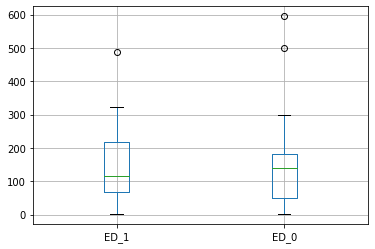

In [131]:
df = dfED.copy()
df =  df.set_index('tokens')

boxplot = df.boxplot() 

In [115]:
df1_transposed = df.T
df1_transposed

tokens,eat,disorder,recovery,edtwt,anorexic,ed,thinspo,binge,food,bulimia,people,anorexia,help,research,problem,study
ED_1,488,323,274,237,210,183,136,118,113,97,90,73,50,36,16,3
ED_0,595,500,128,4,52,43,2,157,300,42,155,126,101,182,182,185
ProED_1,94,20,9,219,155,59,129,40,20,34,21,15,14,2,4,0
ProED_0,989,803,393,22,107,167,9,235,393,105,224,184,137,216,194,188
Inf_1,533,483,137,9,19,41,8,134,139,42,92,82,76,154,59,183
Inf_0,550,340,265,232,243,185,130,141,274,97,153,117,75,64,139,5
Sci_1,339,331,25,2,9,17,1,72,73,24,53,57,38,150,24,181
Sci_0,744,492,377,239,253,209,137,203,340,115,192,142,113,68,174,7
ED_0_a,595,500,128,4,52,43,2,157,300,42,155,126,101,182,182,185
ED_1_a,488,323,274,237,210,183,136,118,113,97,90,73,50,36,16,3


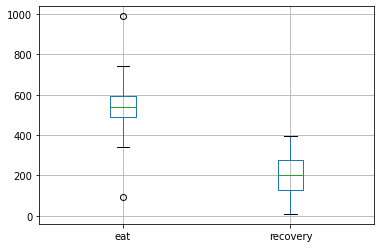

In [117]:
boxplot = df1_transposed.boxplot(column=['eat','recovery']) 

C:\Users\MICROSOFT\Anaconda3\envs\edoct2022\lib\site-packages\seaborn\distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.

C:\Users\MICROSOFT\Anaconda3\envs\edoct2022\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

C:\Users\MICROSOFT\Anaconda3\envs\edoct2022\lib\site-packages\seaborn\distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.

C:\Users\MICROSOFT\Anaconda3\envs\edoct2022\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to u

ValueError: could not convert string to float: 'eat'

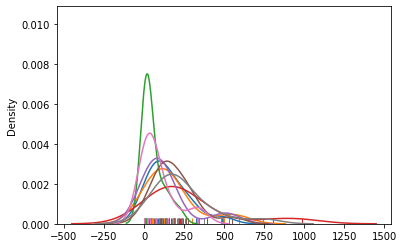

In [102]:
# ----------------------------------------------------------------------
# Plot the distributions (column-wise) (if you just want some columns)
# ----------------------------------------------------------------------
df = mergedRes.copy()
sns.distplot(df[['ED_1']], hist=False, rug=True)
sns.distplot(df[['ED_0']], hist=False, rug=True)
sns.distplot(df[['ProED_1']], hist=False, rug=True)
sns.distplot(df[['ProED_0']], hist=False, rug=True)
sns.distplot(df[['Inf_1']], hist=False, rug=True)
sns.distplot(df[['Inf_0']], hist=False, rug=True)
sns.distplot(df[['Sci_1']], hist=False, rug=True)
sns.distplot(df[['Sci_0']], hist=False, rug=True)
#sns.plt.show()

# ----------------------------------------------------------------------
# Plot the distributions (column-wise) (looping method)
# ----------------------------------------------------------------------
for col in df.columns:
    sns.distplot(df[[col]], hist=False, rug=True)

In [80]:
import gc
del model1,model2,model3
gc.collect()
print(torch.cuda.memory_summary(device=0, abbreviated=False))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 4            |        cudaMalloc retries: 6         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1391 MB |    6527 MB |   12960 GB |   12959 GB |
|       from large pool |    1390 MB |    6518 MB |   12898 GB |   12897 GB |
|       from small pool |       0 MB |      22 MB |      62 GB |      62 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1391 MB |    6527 MB |   12960 GB |   12959 GB |
|       from large pool |    1390 MB |    6518 MB |   12898 GB |